#**Fluxo de Projeto em sistemas embarcados - PPgMECA/UFRN - 2025.1**
### Prof. Josenalde Barbosa de Oliveira
#### Discente: Deivison Luan Xavier Silva

[Descrição completa e detalhada da Atividade 3](https://github.com/josenalde/flux-embedded-design/blob/main/exercises/atividade_3.ipynb)



## **Atividade 3**
A atividade consiste na comparação de desempenho com o uso de paralelismo em dois códigos, estimado do número pi e multiplicação de uma matriz por um vetor.

Em ambos os códigos, os resultados são obtidos de versões com o uso de 1 thread (serial), 1 thread por núcleo e duas threads por núcleo do processador usando a biblioteca pthreads e o conceito de Mutex.

As especificações do hardware utilizado para realizar os testes serão descritas abaixo e após isso, as atividades serão descritas com detalhes

 CPU Model name:       

 **AMD Ryzen 5 5600G with Radeon Graphics**

```
Core(s):                6
Thread(s) por core:     2
```
      
Caches (sum of all):

    L1d:                    192 KiB (6 instances)
    L1i:                    192 KiB (6 instances)
    L2:                     3 MiB (6 instances)
    L3:                     16 MiB (1 instance)
    
---

Operational System (OS):

**Windows 11**

Usando WSL para emular o sistema linux:

```
OS NAME="Ubuntu"
VERSION="24.04.2 LTS (Noble Numbat)"
```




O **repositório com todos os codigos completos** está no link: [https://github.com/DeivisonLuan/PI_Estimator](https://github.com/DeivisonLuan/PI_Estimator)

## Atividade 3.1: Desenvolver código com paradigma paralelo para estimar o número PI

Para nosso objetivo de estimar o número PI, foi adotado o método sugerido pelo prof. Josenalde, onde PI pode ser aproximado pela série de N termos abaixo:

> $\pi = 4 \left ( \frac{1}{1} - \frac{1}{3} + \frac{1}{5} - \frac{1}{7} + \cdots + (-1)^n \frac{1}{2N+1}\right ) $

Buscando uma comparação ainda mais efetiva usaremos o Mutex dentro e fora do loop de execução das threads e veremos o impacto dessa alteração nos resultados.

Portanto, temos:

As variaveis foram definidas conforme mostrado abaixo e o cadeado (mutex) foi criado
```c++
//definição de variaveis globais
#define MaxThread 6 //numero máximo de threads do CPU
#define N 100000 //numero de parcelas somadas
double sum = 0.0;
double parcel[MaxThread] = {0};

//inicializa o mutex com atributos padrão
pthread_mutex_t lock = PTHREAD_MUTEX_INITIALIZER;
```

A função principal é igual pra ambos os programas que usam o Mutex. Seguindo a sequência temos a divisão das threads atribuindo tarefas a elas e ao final das tarefas a reunião das informações (join).

Por fim, é mostrado na tela o tempo de execução e o valor encontrado de PI.

```c++
int main(){
  pthread_t threads[MaxThread];
  int err;
  
  pthread_mutex_init(&lock, NULL); // o segundo parâmetro = NULL significa que usará atributos padrão

  clock_t timeStart, timeEnd;
  timeStart = clock(); //marcar o tempo inicial

  for(long i=0; i<MaxThread; i++){
    err = pthread_create(&threads[i], NULL, pi_parcel, (void*)i);
  }
  
  for (int i=0; i<MaxThread; i++) {
    err  = pthread_join(threads[i], NULL);
  }

  pthread_mutex_destroy(&lock);

  double pi = 4.0*sum;

  timeEnd = clock(); //marca o tempo final
  double execTime = (double)(timeEnd - timeStart)/(double) CLOCKS_PER_SEC;
  cout.precision(12);
  cout << fixed << "Tempo de execução: " << execTime << endl;
  cout << "Numero pi encontrado com " << N << " parcelas somadas: " << pi << endl;
  
  return 0;
}
```

### **Estimador_PI_mutex_InLoop.cpp**: Versão do código incluindo seção crítica controlada por MUTEX dentro do loop

Dentro do for de execução das tarefas o mutex dá acesso a variável sum para uma thread a cada iteração.

```c++
//Função das threads
void* pi_parcel(void* id){
  long thread_id = (long long) id; //typecast
  long long i;
  long long new_N = N/MaxThread;
  long long first_parcel = new_N * thread_id;
  long long last_parcel = first_parcel + new_N;

  for (i = first_parcel; i < last_parcel; i++) {
    pthread_mutex_lock(&lock);
      if (i % 2 == 0) // my first i is even
        sum += 1.0/((2.0*i)+ 1.0);
      else // my first i is odd
        sum -= 1.0/((2.0*i)+ 1.0);
    pthread_mutex_unlock(&lock);
  }
  return NULL; //evita warning
}

```

### **Estimador_PI_mutex_OutLoop.cpp**: Versão do código incluindo seção crítica controlada por MUTEX fora do loop, com variável privada da soma de contribuição de cada thread

Já quando o Mutex está fora do for de execução das tarefas o acesso a variável sum para uma thread ocorre apenas ao final de todas as operações de cada thread.

```c++
//Função das threads
void* pi_parcel(void* id){
  long thread_id = (long long) id; //typecast
  long long i;
  long long new_N = N/MaxThread;
  long long first_parcel = new_N * thread_id;
  long long last_parcel = first_parcel + new_N;

  for (i = first_parcel; i < last_parcel; i++) {
    if (i % 2 == 0) // my first i is even
      parcel[thread_id] += 1/((2*i)+ (double)1);
    else // my first i is odd
      parcel[thread_id] -= 1/((2*i)+ (double)1);
  }

  pthread_mutex_lock(&lock);
        sum += parcel[thread_id];
  pthread_mutex_unlock(&lock);

  return NULL; //evita warning
}

```

### **Estimador_PI_serial.cpp**: Versão do código serial, sem paralelismo, ou seja, com 1 thread

 Para o codigo serial, o trecho abaixo pode ser realizar o calculo das parcelas, bem como sua soma, armazenando o valor final de PI.
 ```c++
 //calcula as parcelas e as soma no resultado
  double sum = 0.0;
  for (int i = 0; i < n; i++) {
      if (i % 2 == 0) // my first i is even
          sum += 1.0/((2.0*i) + 1.0);
      else // my first i is odd
          sum -= 1.0/((2.0*i) + 1.0);
  }
  pi = 4.0*sum;
```

### Resultados:

Na tabela abaixo, temos uma coluna com o PI calculado e uma coluna com o tempo médio de 10 execuções para cada versão (Mutex dentro e fora do loop e cada um usando 1 e 2 threads por core).

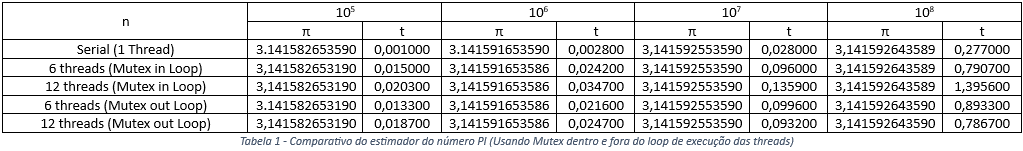

Espera-se que as versões com múltiplas threads apresentem redução significativa no tempo de execução em relação à versão serial, principalmente em sistemas com múltiplos núcleos, como o processador utilizado. Apesar disso, vemos os resultados apresentados na tabela acima e notamos que os tempos e as aproximações não são tão melhores assim, chegando em alguns casos a ser piores, mas por que isto acontece?

A versão com mutex dentro do loop apresentar maior menores tempos médio de execução, já que uma thread acessa a região crítica a cada iteração do loop de tarefa, o que pode diminuir o tempo de espera das outras threads e aumentar o desempenho. Já a versão com mutex fora do loop tende a ser menos eficiente, pois cada thread acumula sua própria soma local e apenas sincroniza uma vez no final, deixando as outras em espera.

No entanto, ambas as versões devem produzir um valor final de PI semelhante, com pequenas diferenças numéricas esperadas por conta da ordem de soma e da quantidade ainda pequana de threads utilizadas. Melhores desempenhos devem ser facilmente identificados com altos numeros de threads e com ainda mais casas decimais avaliadas.

##Atividade 3.2: desenvolver código com paradigma paralelo para multiplicação matrix vetor

Seja uma matriz $A_{m \times n}$, um vetor $x_{n \times 1}$ e um vetor resultante $y_{m \times 1}$ tal que desejamos calcular o produto $Ax=y$. Esta é uma operação comum na resolução de sistemas lineares, com inúmeras aplicações em álgebra (otimização de funções com restrições etc.), transformação de imagens (rotação, aumento de escala etc.).

Assim como na Atividade 3.1, o código de multiplicação de uma matriz por um vetor terá versões com 1 thread (serial), 1 thread por core e 2 threads por core. Além disso, pede-se que cada versão seja executada 10 vezes ou mais para ser obter a média de tempo.

DICA: preencher a matriz $A$ e o vetor $x$ com valores DOUBLE aleatórios entre 0 e 5

Como não há problema com choque de atualização de variáveis globais (race condition), então no código as variaveis relativas a matriz e os vetores x e y são globais e compartilhadas. A definição é descrita abaixo:

```c++
//definição de variaveis globais
#define M 8 //numero de linhas
#define N 8000000 //numero de colunas
double matrix[M][N] = {0};
double vectorX[N] = {0}, vectorY[M] = {0};
```

### **Matriz_x_Vetor_serial.cpp**: Versão paralela da multiplicação da matriz $A$ pelo vetor $x$


A abaixo estão as funções de multiplicação, e geração de elementos aleatórios da matriz e do vetor:

```c++
//Função das threads
void Ax_vector(){    
    for (int i = 0; i <= M; i++) {
        vectorY[i] = 0.0;
        for (int j = 0; j < N; j++)
            vectorY[i] += matrix[i][j] * vectorX[j];
    }
}

void generateMatrix(double *m, int line, int column){
  for (int i = 0; i < line; ++i) {
    for (int j = 0; j < column; ++j){
      *(m + i * column + j) = rand() % 5 + 1;
    }
  }
}

void generateVector(double *v, int lenght){
  for (int i = 0; i < lenght; ++i) {
    v[i] = rand() % 5 + 1;
  }
}
```

### **Matriz_x_Vetor.cpp**: Versão paralela da multiplicação da matriz $A$ pelo vetor $x$

A função main tem a estrutura igual a do item 3.1, com mudança apenas nos argumentos da chamada da função de criação das threads, que chama a função abaixo:

```c++
//Função das threads
void* Ax_vector(void* id){
  long thread_id = (long long) id; //typecast
  int i, j;
  int local_m = M/MaxThread;
  int my_start = thread_id * local_m;
  int my_end = (thread_id+1) * local_m - 1;
  for (i = my_start; i <= my_end; i++) {
      vectorY[i] = 0.0;
      for (j = 0; j < N; j++)
          vectorY[i] += matrix[i][j] * vectorX[j];
  }
  return NULL; //evita warning
}
```

### **Resultados**:

Os testes foram realizados com matrizes $A_{m \times n}$ e vetores $x_{n \times 1}$ preenchidos com valores aleatorios entre 0 e 5, onde os valores de $m$ e $n$, são:

a) $m$ = 8000000, $n$ = 8

b) $m$ = 8000, $n$ = 8000

c) $m$ = 8, $n$ = 8000000





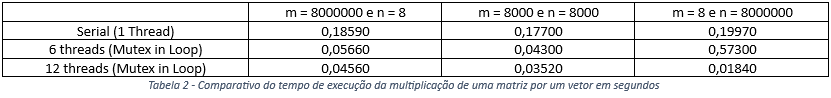

Na multiplicação matriz por vetor, espera-se que o paralelismo traga benefícios mais evidentes nos casos onde m é grande, ou seja, onde há muitas linhas a serem processadas em paralelo. Aqui os resultados se alinham mais com o esperado, e isso se dá muito pela divisão de tarefas por tasks. Considerando que as divisões são iguais, então cada thread tem muitas linhas paras executar, o que evidencia o poder do paralelismo.

No caso (a), com 8 milhões de linhas, o paralelismo deve escalar muito bem. No caso (b), onde a matriz é quadrada, o paralelismo também ajuda, mas as atividades executadas pelas threas é as operações nas linhas, assim com um numero de linhas menor cada thread encerra sua atividade mais rapido, mas trabalham mais vezes, pois o número de colunas aumentou. Já o caso (c), o que ocorre no item anterior só se agrava, com poucas linhas e muitas colunas, o código tende a não se beneficiar do paralelismo, pois há pouco trabalho para threads ativamente trabalhando e esse pouco trabalho é executado muitas vezes, pois o número de colunas é maior.

Esse cenário pode até ter desempenho pior dependendo da implementação. Assim, o paralelismo é positivo principalmente em tarefas massivamente paralelizáveis, mas seu uso inadequado (como em pequenas quantidades de trabalho ou excesso de sincronização) pode levar a resultados pouco eficazes.